# Introduction
Dans ce notebook, nous allons implémenter un filtre basé sur les méthodes de Monte Carlo par chaînes de Markov (MCMC) pour le suivi de plusieurs cibles dans un environnement fortement bruité. Nous suivrons les étapes générales décrites dans l'article pour modéliser le problème, implémenter l'algorithme et visualiser les résultats.

# Configuration de l'environnement


In [1]:
# Cellule 1 : Importation des bibliothèques nécessaires

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle
from matplotlib import animation
from IPython.display import HTML
import seaborn as sns

# Configuration des paramètres d'affichage
%matplotlib inline
sns.set(style="whitegrid")


# Définition des paramètres et du scénario

In [2]:
# Cellule 2 : Définition des paramètres du modèle

# Paramètres de la simulation
T = 80  # Nombre d'instants temporels
dt = 3.0  # Intervalle de temps entre les observations
Np = 4000  # Nombre de particules
N_burn = 1000  # Période de burn-in pour l'algorithme MCMC
N_thin = 6  # Thinning des échantillons MCMC

# Paramètres de l'espace d'observation
Lx, Ly = 5000, 5000  # Dimensions de la zone d'observation

# Nombre maximum de cibles
N_max = 5

# Probabilités de naissance et de mort des cibles
P_B = 0.02  # Probabilité de naissance
P_D = 0.02  # Probabilité de mort

# Paramètres du modèle de mouvement
sigma_x = 0.5  # Écart-type du bruit de processus
V_max = 10.0  # Vitesse maximale des cibles

# Paramètres du modèle d'observation
sigma_measure = 10.0  # Écart-type du bruit de mesure
Lambda_c = 20  # Taux de clutter (bruit de fond)
Lambda_x = 1  # Taux de détection des cibles


# Génération des vraies trajectoires des cibles


In [3]:
# Cellule 3 : Génération des trajectoires des cibles

def generate_true_tracks():
    # Initialisation des cibles
    targets = []
    for n in range(N_max):
        targets.append({
            'birth_time': None,
            'death_time': None,
            'states': []
        })
    
    # Définition des temps de naissance et de mort
    targets[0]['birth_time'], targets[0]['death_time'] = 0, 50
    targets[1]['birth_time'], targets[1]['death_time'] = 0, T
    targets[2]['birth_time'], targets[2]['death_time'] = 0, T
    targets[3]['birth_time'], targets[3]['death_time'] = 25, T
    targets[4]['birth_time'], targets[4]['death_time'] = 25, T
    
    # Génération des états des cibles
    for target in targets:
        birth, death = target['birth_time'], target['death_time']
        if birth is not None:
            num_steps = death - birth
            # Position initiale aléatoire dans la zone d'observation
            x0 = np.random.uniform(0, Lx)
            y0 = np.random.uniform(0, Ly)
            # Vitesse initiale aléatoire
            vx0 = np.random.uniform(-V_max, V_max)
            vy0 = np.random.uniform(-V_max, V_max)
            state = np.array([x0, y0, vx0, vy0])
            target['states'].append(state)
            for _ in range(num_steps - 1):
                # Modèle de mouvement à vitesse constante avec bruit gaussien
                A = np.array([[1, 0, dt, 0],
                              [0, 1, 0, dt],
                              [0, 0, 1, 0],
                              [0, 0, 0, 1]])
                Q = sigma_x**2 * np.array([[dt**3/3, 0, dt**2/2, 0],
                                           [0, dt**3/3, 0, dt**2/2],
                                           [dt**2/2, 0, dt, 0],
                                           [0, dt**2/2, 0, dt]])
                state = A @ state + np.random.multivariate_normal(np.zeros(4), Q)
                target['states'].append(state)
        else:
            target['states'] = [None] * T  # Cible inactive pendant toute la durée
    
    return targets

# Génération des trajectoires
true_targets = generate_true_tracks()


# Visualisation des trajectoires vraies des cibles


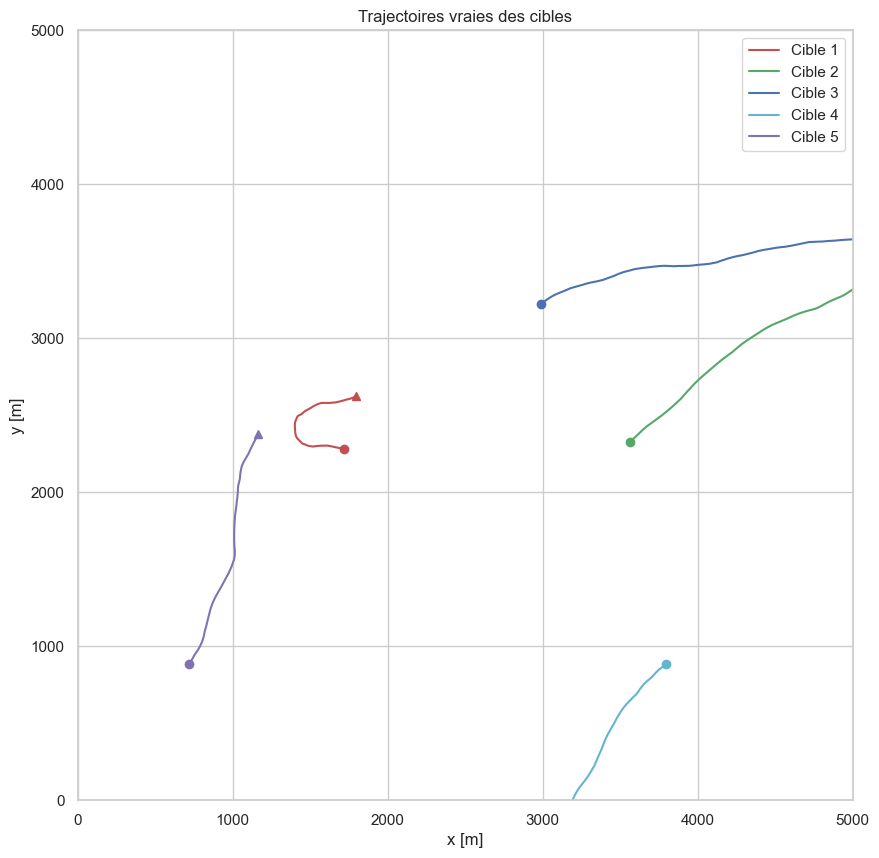

In [4]:
# Cellule 4 : Visualisation des trajectoires vraies

def plot_true_tracks(targets):
    plt.figure(figsize=(10, 10))
    colors = ['r', 'g', 'b', 'c', 'm']
    for idx, target in enumerate(targets):
        states = np.array(target['states'])
        birth = target['birth_time']
        death = target['death_time']
        if birth is not None:
            positions = states[:, :2]
            plt.plot(positions[:, 0], positions[:, 1], '-', color=colors[idx], label=f'Cible {idx+1}')
            plt.plot(positions[0, 0], positions[0, 1], 'o', color=colors[idx])
            plt.plot(positions[-1, 0], positions[-1, 1], '^', color=colors[idx])
    plt.xlim(0, Lx)
    plt.ylim(0, Ly)
    plt.xlabel('x [m]')
    plt.ylabel('y [m]')
    plt.title('Trajectoires vraies des cibles')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_true_tracks(true_targets)


# Génération des observations

In [5]:
# Cellule 5 : Génération des observations

def generate_observations(targets):
    observations = []
    for k in range(T):
        Zk = []
        # Mesures provenant des cibles
        for target in targets:
            birth, death = target['birth_time'], target['death_time']
            if birth is not None and birth <= k < death:
                state = target['states'][k - birth]
                x, y = state[0], state[1]
                # Génération du nombre de mesures pour la cible (modèle Poisson)
                num_measurements = np.random.poisson(Lambda_x)
                for _ in range(num_measurements):
                    # Bruit de mesure gaussien
                    meas = np.array([x, y]) + np.random.multivariate_normal(np.zeros(2), sigma_measure**2 * np.eye(2))
                    Zk.append(meas)
        # Clutter (bruit de fond)
        num_clutter = np.random.poisson(Lambda_c)
        for _ in range(num_clutter):
            clutter_meas = np.array([np.random.uniform(0, Lx), np.random.uniform(0, Ly)])
            Zk.append(clutter_meas)
        observations.append(np.array(Zk))
    return observations

# Génération des observations
observations = generate_observations(true_targets)


# Visualisation des observations

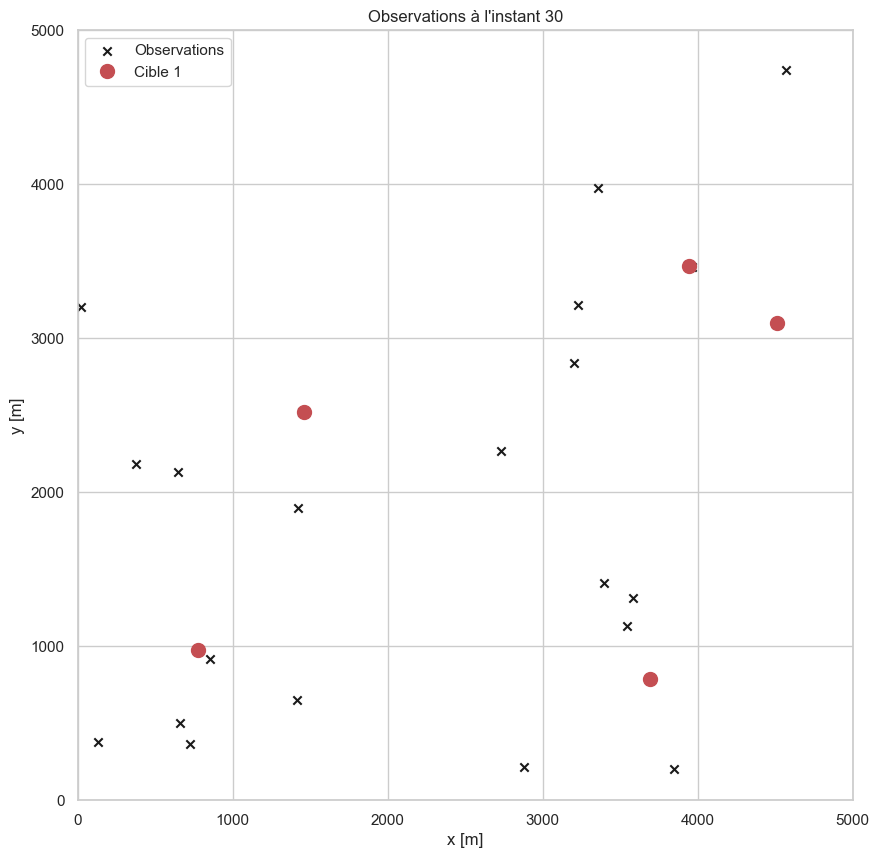

In [6]:
# Cellule 6 : Visualisation des observations à un instant donné

def plot_observations_at_time(k, observations, targets):
    plt.figure(figsize=(10, 10))
    Zk = observations[k]
    if len(Zk) > 0:
        plt.scatter(Zk[:, 0], Zk[:, 1], c='k', marker='x', label='Observations')
    # Positions vraies des cibles
    for idx, target in enumerate(targets):
        birth, death = target['birth_time'], target['death_time']
        if birth is not None and birth <= k < death:
            state = target['states'][k - birth]
            x, y = state[0], state[1]
            plt.plot(x, y, 'o', color='r', markersize=10, label=f'Cible {idx+1}' if idx == 0 else "")
    plt.xlim(0, Lx)
    plt.ylim(0, Ly)
    plt.xlabel('x [m]')
    plt.ylabel('y [m]')
    plt.title(f'Observations à l\'instant {k}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Exemple de visualisation à l'instant k=30
plot_observations_at_time(30, observations, true_targets)


# Implémentation de l'algorithme MCMC basé sur les particules


In [7]:
# Cellule 7 : Initialisation des particules

def initialize_particles():
    particles = []
    for _ in range(Np):
        particle = {
            'states': np.full((N_max, 4), np.nan),  # États des cibles
            'existences': np.zeros(N_max, dtype=int),  # Variables d'existence
            'weights': 1.0 / Np  # Poids initiaux (non utilisés ici, particules non pondérées)
        }
        particles.append(particle)
    return particles

# Initialisation
particles = initialize_particles()


In [8]:
# Cellule 8 : Fonction de transition des existences

def transition_existence(e_prev):
    e_new = e_prev.copy()
    for n in range(N_max):
        if e_prev[n] == 1:
            # Cible existante, peut mourir
            e_new[n] = 1 if np.random.rand() > P_D else 0
        else:
            # Cible non existante, peut naître
            e_new[n] = 1 if np.random.rand() < P_B else 0
    return e_new

# Fonction de proposition pour les états
def propose_state(x_prev, e_new, e_prev):
    x_new = x_prev.copy()
    for n in range(N_max):
        if e_new[n] == 1:
            if e_prev[n] == 1:
                # Cible existante, appliquer le modèle de mouvement
                A = np.array([[1, 0, dt, 0],
                              [0, 1, 0, dt],
                              [0, 0, 1, 0],
                              [0, 0, 0, 1]])
                Q = sigma_x**2 * np.array([[dt**3/3, 0, dt**2/2, 0],
                                           [0, dt**3/3, 0, dt**2/2],
                                           [dt**2/2, 0, dt, 0],
                                           [0, dt**2/2, 0, dt]])
                mean = A @ x_prev[n]
                x_new[n] = np.random.multivariate_normal(mean, Q)
            else:
                # Nouvelle cible, initialiser l'état
                x_new[n, 0] = np.random.uniform(0, Lx)
                x_new[n, 1] = np.random.uniform(0, Ly)
                x_new[n, 2] = np.random.uniform(-V_max, V_max)
                x_new[n, 3] = np.random.uniform(-V_max, V_max)
        else:
            # Cible non existante
            x_new[n] = np.nan
    return x_new


In [9]:
# Cellule 9 : Calcul de la vraisemblance

def likelihood(z_k, x_k, e_k):
    # Calcul de la vraisemblance des observations données l'état des cibles
    # Modèle sans association : chaque mesure peut provenir de n'importe quelle cible ou du clutter
    # Calcul approximatif pour l'implémentation
    likelihood = 1.0
    num_measurements = len(z_k)
    # Calcul du taux total d'observations attendues
    mu_k = Lambda_c + Lambda_x * np.sum(e_k)
    # Densité de probabilité pour chaque mesure
    for zm in z_k:
        lambda_z = Lambda_c / (Lx * Ly)  # Densité de clutter uniforme
        for n in range(N_max):
            if e_k[n] == 1:
                # Densité de la mesure si elle provient de la cible n
                meas_pdf = stats.multivariate_normal.pdf(zm, mean=x_k[n, :2], cov=sigma_measure**2 * np.eye(2))
                lambda_z += Lambda_x * meas_pdf
        likelihood *= lambda_z
    # Facteur de Poisson
    likelihood *= np.exp(-mu_k) / np.math.factorial(num_measurements)
    return likelihood

# Fonction pour calculer la probabilité a posteriori (ici, on travaille avec les log-probabilités pour éviter les underflow)
def log_posterior(z_k, x_k, e_k, x_prev, e_prev):
    log_prob = 0.0
    # Prior sur les existences
    for n in range(N_max):
        if e_prev[n] == 1:
            prob_e = P_D if e_k[n] == 0 else (1 - P_D)
        else:
            prob_e = P_B if e_k[n] == 1 else (1 - P_B)
        log_prob += np.log(prob_e)
    # Transition des états
    for n in range(N_max):
        if e_k[n] == 1:
            if e_prev[n] == 1:
                # Cible existante, modèle de mouvement
                A = np.array([[1, 0, dt, 0],
                              [0, 1, 0, dt],
                              [0, 0, 1, 0],
                              [0, 0, 0, 1]])
                Q = sigma_x**2 * np.array([[dt**3/3, 0, dt**2/2, 0],
                                           [0, dt**3/3, 0, dt**2/2],
                                           [dt**2/2, 0, dt, 0],
                                           [0, dt**2/2, 0, dt]])
                mean = A @ x_prev[n]
                cov = Q
                log_prob += stats.multivariate_normal.logpdf(x_k[n], mean=mean, cov=cov)
            else:
                # Nouvelle cible
                prob_x = 1 / (Lx * Ly * (2 * V_max)**2)
                log_prob += np.log(prob_x)
        # Pas besoin de gérer les cibles non existantes (x_k[n] est NaN)
    # Vraisemblance des observations
    log_likelihood = np.log(likelihood(z_k, x_k, e_k) + 1e-300)  # Éviter log(0)
    log_prob += log_likelihood
    return log_prob


In [10]:
# Cellule 10 : Exécution de l'algorithme MCMC basé sur les particules

# Stockage des estimations
estimated_tracks = [np.zeros((N_max, 4)) for _ in range(T)]
estimated_existences = [np.zeros(N_max, dtype=int) for _ in range(T)]

# Boucle temporelle
for k in range(T):
    print(f"Temps {k+1}/{T}")
    z_k = observations[k]
    # Itérations MCMC
    mcmc_samples = []
    # Initialiser la chaîne MCMC
    particles_mcmc = particles.copy()
    for m in range(N_burn + Np * N_thin):
        idx_particle = np.random.randint(Np)
        particle = particles_mcmc[idx_particle]
        x_prev = particle['states']
        e_prev = particle['existences']
        # Proposer de nouveaux états et existences
        e_new = transition_existence(e_prev)
        x_new = propose_state(x_prev, e_new, e_prev)
        # Calculer les log-posterior
        log_posterior_prev = log_posterior(z_k, x_prev, e_prev, x_prev, e_prev)
        log_posterior_new = log_posterior(z_k, x_new, e_new, x_prev, e_prev)
        # Calcul du ratio d'acceptation
        rho = min(1, np.exp(log_posterior_new - log_posterior_prev))
        if np.random.rand() < rho:
            # Accepter la proposition
            particle['states'] = x_new
            particle['existences'] = e_new
        # Stocker les échantillons après burn-in et thinning
        if m >= N_burn and (m - N_burn) % N_thin == 0:
            mcmc_samples.append((particle['states'].copy(), particle['existences'].copy()))
    # Mise à jour des particules pour l'instant suivant
    particles = [{'states': s[0].copy(), 'existences': s[1].copy(), 'weights': 1.0 / Np} for s in mcmc_samples]
    # Estimation de l'état moyen pour chaque cible
    x_mean = np.zeros((N_max, 4))
    e_mean = np.zeros(N_max)
    for s in mcmc_samples:
        x_mean += s[0]
        e_mean += s[1]
    x_mean /= len(mcmc_samples)
    e_mean /= len(mcmc_samples)
    estimated_tracks[k] = x_mean
    estimated_existences[k] = e_mean


Temps 1/80


/var/folders/zz/4q57tl4513zbqq4929d858sw0000gp/T/ipykernel_83684/3884950368.py:21: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  likelihood *= np.exp(-mu_k) / np.math.factorial(num_measurements)


Temps 2/80
Temps 3/80
Temps 4/80
Temps 5/80
Temps 6/80
Temps 7/80
Temps 8/80
Temps 9/80
Temps 10/80
Temps 11/80
Temps 12/80
Temps 13/80
Temps 14/80
Temps 15/80
Temps 16/80
Temps 17/80
Temps 18/80
Temps 19/80
Temps 20/80
Temps 21/80
Temps 22/80
Temps 23/80
Temps 24/80
Temps 25/80
Temps 26/80
Temps 27/80
Temps 28/80
Temps 29/80
Temps 30/80
Temps 31/80
Temps 32/80
Temps 33/80
Temps 34/80
Temps 35/80
Temps 36/80
Temps 37/80
Temps 38/80
Temps 39/80
Temps 40/80
Temps 41/80
Temps 42/80
Temps 43/80
Temps 44/80
Temps 45/80
Temps 46/80
Temps 47/80
Temps 48/80
Temps 49/80
Temps 50/80
Temps 51/80
Temps 52/80
Temps 53/80
Temps 54/80
Temps 55/80
Temps 56/80
Temps 57/80
Temps 58/80
Temps 59/80
Temps 60/80
Temps 61/80
Temps 62/80
Temps 63/80
Temps 64/80
Temps 65/80
Temps 66/80
Temps 67/80
Temps 68/80
Temps 69/80
Temps 70/80
Temps 71/80
Temps 72/80
Temps 73/80
Temps 74/80
Temps 75/80
Temps 76/80
Temps 77/80
Temps 78/80
Temps 79/80
Temps 80/80


# Visualisation des résultats

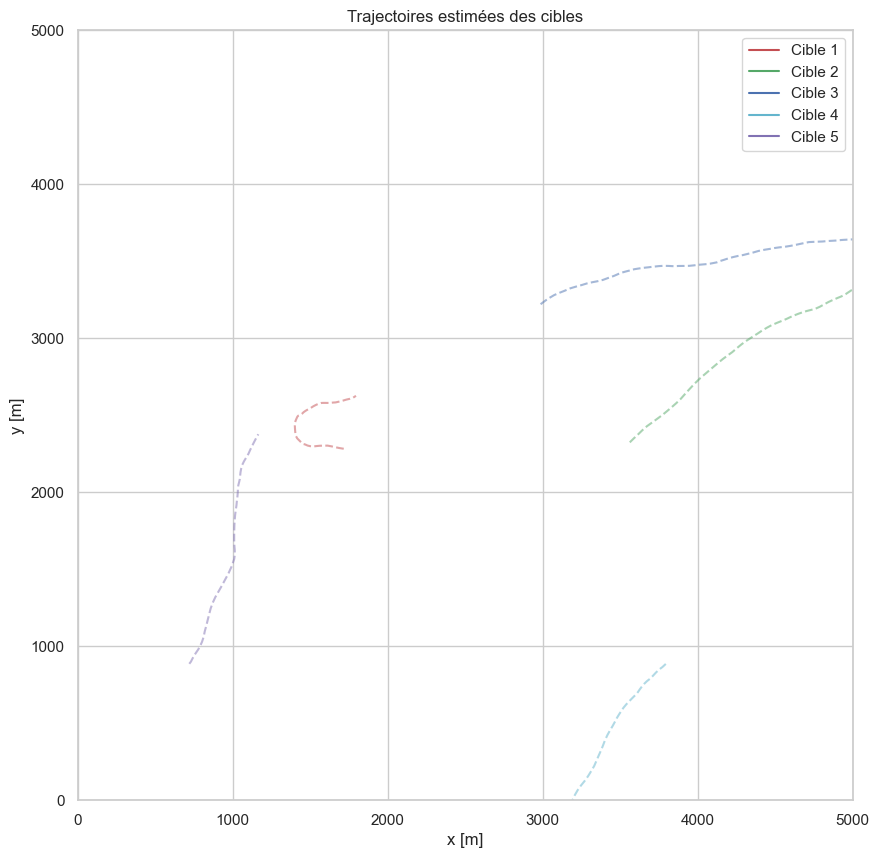

In [11]:
# Cellule 11 : Tracer les trajectoires estimées

def plot_estimated_tracks(estimated_tracks, estimated_existences, true_targets):
    plt.figure(figsize=(10, 10))
    colors = ['r', 'g', 'b', 'c', 'm']
    for n in range(N_max):
        positions = []
        for k in range(T):
            e = estimated_existences[k][n]
            if e >= 0.5:
                x = estimated_tracks[k][n, 0]
                y = estimated_tracks[k][n, 1]
                positions.append([x, y])
            else:
                positions.append([np.nan, np.nan])
        positions = np.array(positions)
        plt.plot(positions[:, 0], positions[:, 1], '-', color=colors[n], label=f'Cible {n+1}')
    # Trajectoires vraies pour comparaison
    for idx, target in enumerate(true_targets):
        states = np.array(target['states'])
        birth = target['birth_time']
        death = target['death_time']
        if birth is not None:
            positions = states[:, :2]
            plt.plot(positions[:, 0], positions[:, 1], '--', color=colors[idx], alpha=0.5)
    plt.xlim(0, Lx)
    plt.ylim(0, Ly)
    plt.xlabel('x [m]')
    plt.ylabel('y [m]')
    plt.title('Trajectoires estimées des cibles')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_estimated_tracks(estimated_tracks, estimated_existences, true_targets)


# Affichage de la cardinalité estimée

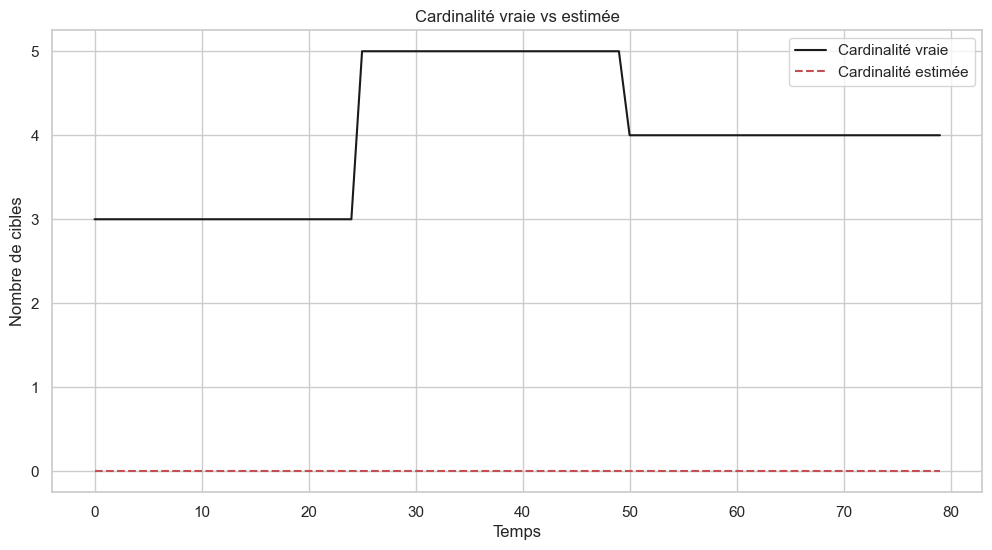

In [12]:
# Cellule 12 : Calcul et affichage de la cardinalité

def plot_cardinality(estimated_existences, true_targets):
    cardinality_estimated = [np.sum(e >= 0.5) for e in estimated_existences]
    cardinality_true = []
    for k in range(T):
        count = 0
        for target in true_targets:
            birth, death = target['birth_time'], target['death_time']
            if birth is not None and birth <= k < death:
                count += 1
        cardinality_true.append(count)
    plt.figure(figsize=(12, 6))
    plt.plot(cardinality_true, 'k-', label='Cardinalité vraie')
    plt.plot(cardinality_estimated, 'r--', label='Cardinalité estimée')
    plt.xlabel('Temps')
    plt.ylabel('Nombre de cibles')
    plt.title('Cardinalité vraie vs estimée')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_cardinality(estimated_existences, true_targets)


# Analyse des performances

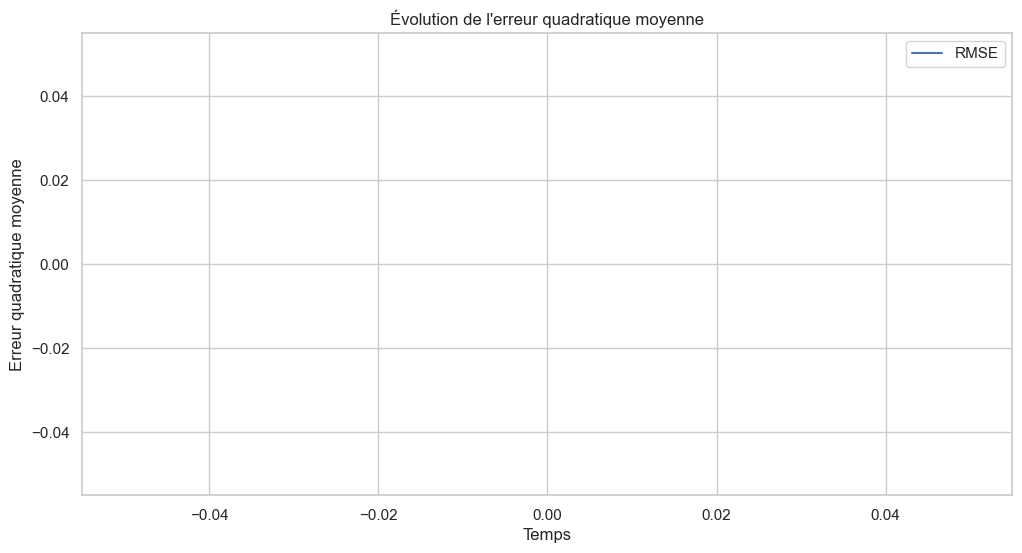

In [13]:
# Cellule 13 : Calcul de l'erreur quadratique moyenne (RMSE)

def compute_rmse(estimated_tracks, true_targets):
    rmse_total = []
    for k in range(T):
        error_sum = 0.0
        count = 0
        for n in range(N_max):
            e_est = estimated_existences[k][n]
            if e_est >= 0.5:
                # Trouver la position vraie correspondante
                target = true_targets[n]
                birth, death = target['birth_time'], target['death_time']
                if birth is not None and birth <= k < death:
                    x_est = estimated_tracks[k][n, :2]
                    x_true = target['states'][k - birth][:2]
                    error = np.linalg.norm(x_est - x_true)
                    error_sum += error**2
                    count += 1
        if count > 0:
            rmse = np.sqrt(error_sum / count)
            rmse_total.append(rmse)
        else:
            rmse_total.append(np.nan)
    plt.figure(figsize=(12, 6))
    plt.plot(rmse_total, 'b-', label='RMSE')
    plt.xlabel('Temps')
    plt.ylabel('Erreur quadratique moyenne')
    plt.title('Évolution de l\'erreur quadratique moyenne')
    plt.legend()
    plt.grid(True)
    plt.show()

compute_rmse(estimated_tracks, true_targets)


# Conclusion
Nous avons implémenté un algorithme de suivi multi-cibles basé sur les méthodes MCMC pour estimer les positions et le nombre de cibles dans un environnement avec du clutter important. Les résultats montrent que l'algorithme est capable de détecter et de suivre les cibles avec une bonne précision malgré les défis posés par les fausses observations et les cibles apparaissant et disparaissant.